# Clasificador de Pulsares

In [1]:
import seaborn as sns

from src.common import *

# Exploratory Data Analysis

Data load and feature naming

In [2]:
filename = "https://raw.githubusercontent.com/charitarthchugh/PulsarIdentification/master/HTRU_2.csv"
features = [
    "Mean of the integrated profile",
    "Standard deviation of the integrated profile",
    "Excess kurtosis of the integrated profile",
    "Skewness of the integrated profile",
    "Mean of the DM-SNR curve",
    "Standard deviation of the DM-SNR curve",
    "Excess kurtosis of the DM-SNR curve",
    "Skewness of the DM-SNR curve"
]
target = "target_class"

In [3]:
df = pd.read_csv(
    filename,
    names=features+[target]
)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17898 entries, 0 to 17897
Data columns (total 9 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   Mean of the integrated profile                17898 non-null  float64
 1   Standard deviation of the integrated profile  17898 non-null  float64
 2   Excess kurtosis of the integrated profile     17898 non-null  float64
 3   Skewness of the integrated profile            17898 non-null  float64
 4   Mean of the DM-SNR curve                      17898 non-null  float64
 5   Standard deviation of the DM-SNR curve        17898 non-null  float64
 6   Excess kurtosis of the DM-SNR curve           17898 non-null  float64
 7   Skewness of the DM-SNR curve                  17898 non-null  float64
 8   target_class                                  17898 non-null  int64  
dtypes: float64(8), int64(1)
memory usage: 1.2 MB


In [5]:
df

,Mean of the integrated profile,Standard deviation of the integrated profile,Excess kurtosis of the integrated profile,Skewness of the integrated profile,Mean of the DM-SNR curve,Standard deviation of the DM-SNR curve,Excess kurtosis of the DM-SNR curve,Skewness of the DM-SNR curve,target_class
0,140.562500,55.683782,-0.234571,-0.699648,3.199833,19.110426,7.975532,74.242225,0
1,102.507812,58.882430,0.465318,-0.515088,1.677258,14.860146,10.576487,127.393580,0
2,103.015625,39.341649,0.323328,1.051164,3.121237,21.744669,7.735822,63.171909,0
3,136.750000,57.178449,-0.068415,-0.636238,3.642977,20.959280,6.896499,53.593661,0
4,88.726562,40.672225,0.600866,1.123492,1.178930,11.468720,14.269573,252.567306,0
...,...,...,...,...,...,...,...,...,...
17893,136.429688,59.847421,-0.187846,-0.738123,1.296823,12.166062,15.450260,285.931022,0
17894,122.554688,49.485605,0.127978,0.323061,16.409699,44.626893,2.945244,8.297092,0
17895,119.335938,59.935939,0.159363,-0.743025,21.430602,58.872000,2.499517,4.595173,0
17896,114.507812,53.902400,0.201161,-0.024789,1.946488,13.381731,10.007967,134.238910,0


In [6]:
df.describe()

,Mean of the integrated profile,Standard deviation of the integrated profile,Excess kurtosis of the integrated profile,Skewness of the integrated profile,Mean of the DM-SNR curve,Standard deviation of the DM-SNR curve,Excess kurtosis of the DM-SNR curve,Skewness of the DM-SNR curve,target_class
count,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000
mean,111.079968,46.549532,0.477857,1.770279,12.614400,26.326515,8.303556,104.857709,0.091574
std,25.652935,6.843189,1.064040,6.167913,29.472897,19.470572,4.506092,106.514540,0.288432
min,5.812500,24.772042,-1.876011,-1.791886,0.213211,7.370432,-3.139270,-1.976976,0.000000
25%,100.929688,42.376018,0.027098,-0.188572,1.923077,14.437332,5.781506,34.960504,0.000000
50%,115.078125,46.947479,0.223240,0.198710,2.801839,18.461316,8.433515,83.064556,0.000000
75%,127.085938,51.023202,0.473325,0.927783,5.464256,28.428104,10.702959,139.309330,0.000000
max,192.617188,98.778911,8.069522,68.101622,223.392141,110.642211,34.539844,1191.000837,1.000000


### Features distribution and correlations

In [7]:
df["target_class"].value_counts()

target_class
0    16259
1     1639
Name: count, dtype: int64

In [8]:
df["target_class"].value_counts(normalize=True)*100

target_class
0    90.842552
1     9.157448
Name: proportion, dtype: float64

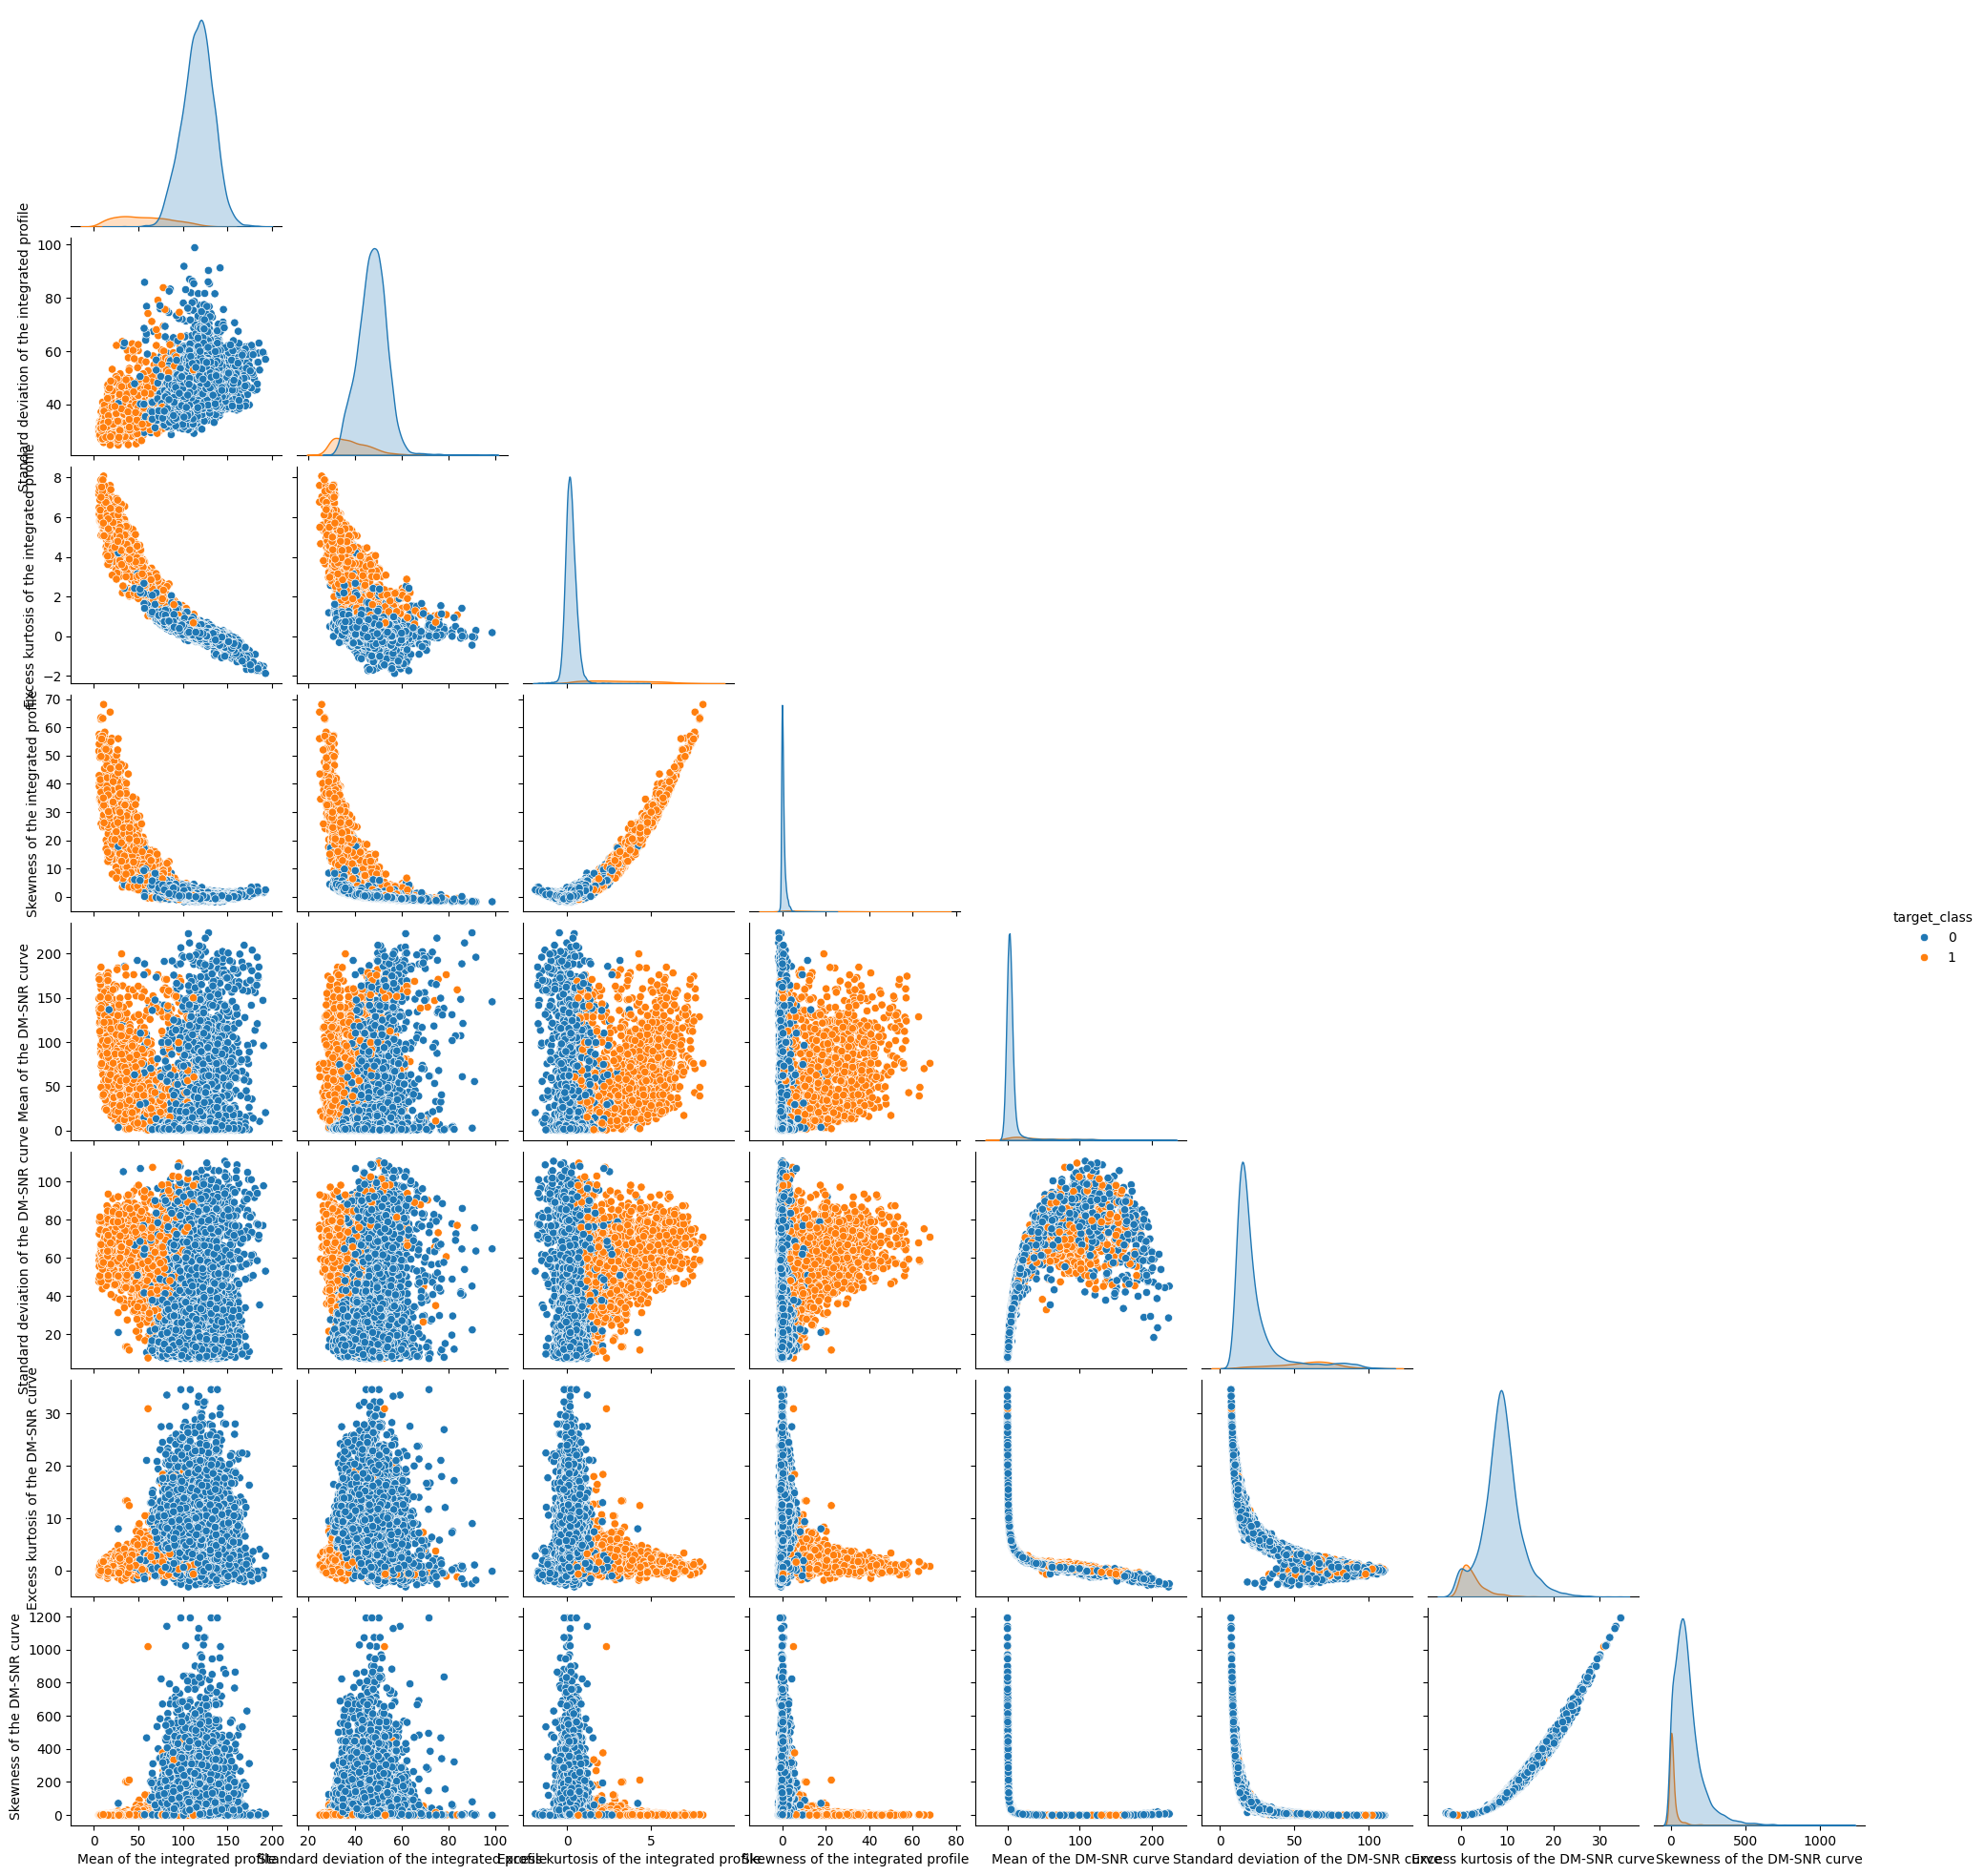

In [9]:
sns.pairplot(
    data = df,
    hue = "target_class",
    corner = True
);

<Axes: >

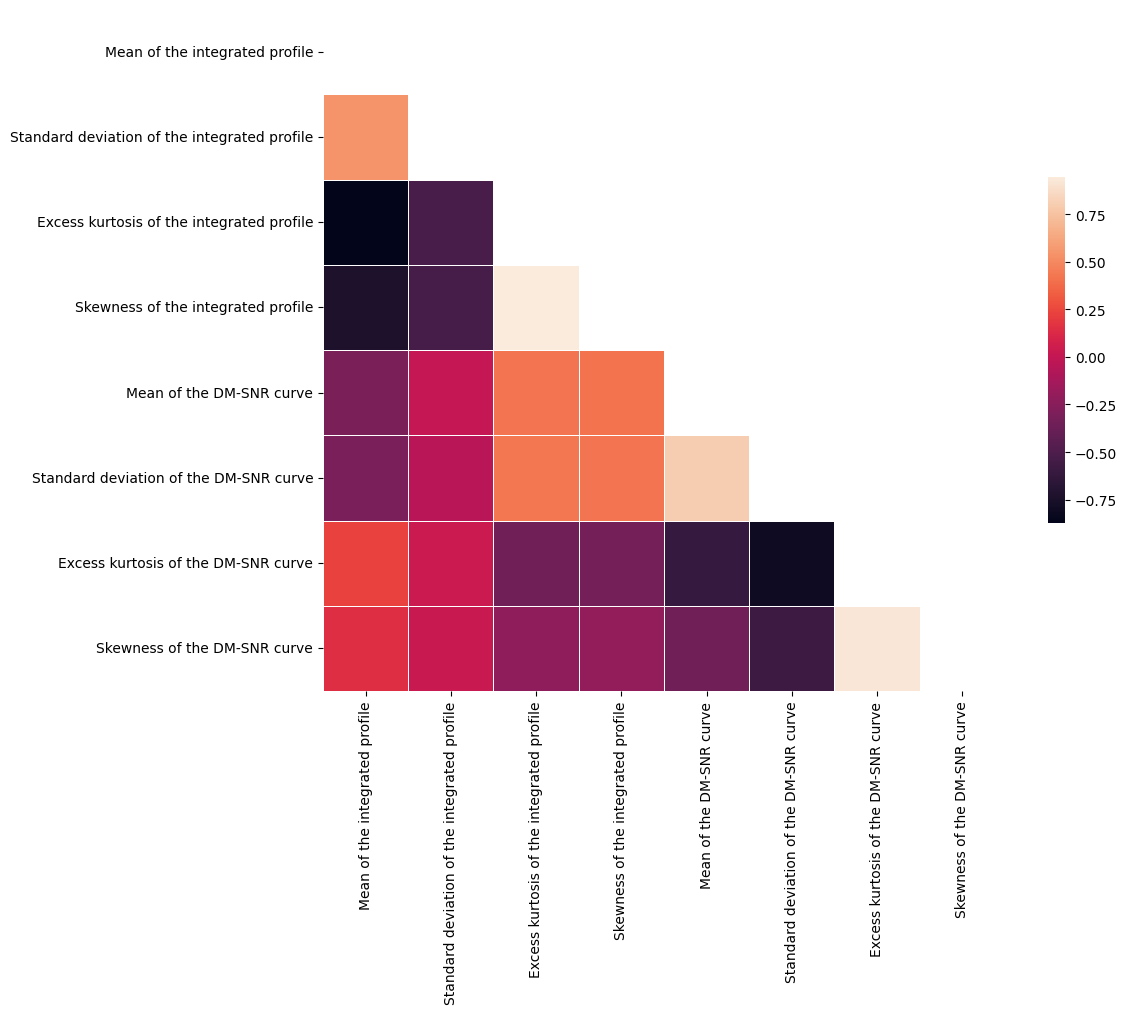

In [10]:
# Compute the correlation matrix
corr = df[features].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr,
    mask=mask, 
    square=True,
    linewidths=.5,
    cbar_kws={"shrink": .5}
)

In [11]:
corr

,Mean of the integrated profile,Standard deviation of the integrated profile,Excess kurtosis of the integrated profile,Skewness of the integrated profile,Mean of the DM-SNR curve,Standard deviation of the DM-SNR curve,Excess kurtosis of the DM-SNR curve,Skewness of the DM-SNR curve
Mean of the integrated profile,1.000000,0.547137,-0.873898,-0.738775,-0.298841,-0.307016,0.234331,0.144033
Standard deviation of the integrated profile,0.547137,1.000000,-0.521435,-0.539793,0.006869,-0.047632,0.029429,0.027691
Excess kurtosis of the integrated profile,-0.873898,-0.521435,1.000000,0.945729,0.414368,0.432880,-0.341209,-0.214491
Skewness of the integrated profile,-0.738775,-0.539793,0.945729,1.000000,0.412056,0.415140,-0.328843,-0.204782
Mean of the DM-SNR curve,-0.298841,0.006869,0.414368,0.412056,1.000000,0.796555,-0.615971,-0.354269
Standard deviation of the DM-SNR curve,-0.307016,-0.047632,0.432880,0.415140,0.796555,1.000000,-0.809786,-0.575800
Excess kurtosis of the DM-SNR curve,0.234331,0.029429,-0.341209,-0.328843,-0.615971,-0.809786,1.000000,0.923743
Skewness of the DM-SNR curve,0.144033,0.027691,-0.214491,-0.204782,-0.354269,-0.575800,0.923743,1.000000


In [12]:
# feature selection
features = [
    "Mean of the integrated profile",
    "Standard deviation of the integrated profile",
    #"Excess kurtosis of the integrated profile",
    "Excess kurtosis of the integrated profile",
    "Skewness of the integrated profile",
    "Mean of the DM-SNR curve",
    "Standard deviation of the DM-SNR curve",
    #"Excess kurtosis of the DM-SNR curve",
    "Excess kurtosis of the DM-SNR curve",
    "Skewness of the DM-SNR curve"
]

df = df[features+[target]]
df

,Mean of the integrated profile,Standard deviation of the integrated profile,Excess kurtosis of the integrated profile,Skewness of the integrated profile,Mean of the DM-SNR curve,Standard deviation of the DM-SNR curve,Excess kurtosis of the DM-SNR curve,Skewness of the DM-SNR curve,target_class
0,140.562500,55.683782,-0.234571,-0.699648,3.199833,19.110426,7.975532,74.242225,0
1,102.507812,58.882430,0.465318,-0.515088,1.677258,14.860146,10.576487,127.393580,0
2,103.015625,39.341649,0.323328,1.051164,3.121237,21.744669,7.735822,63.171909,0
3,136.750000,57.178449,-0.068415,-0.636238,3.642977,20.959280,6.896499,53.593661,0
4,88.726562,40.672225,0.600866,1.123492,1.178930,11.468720,14.269573,252.567306,0
...,...,...,...,...,...,...,...,...,...
17893,136.429688,59.847421,-0.187846,-0.738123,1.296823,12.166062,15.450260,285.931022,0
17894,122.554688,49.485605,0.127978,0.323061,16.409699,44.626893,2.945244,8.297092,0
17895,119.335938,59.935939,0.159363,-0.743025,21.430602,58.872000,2.499517,4.595173,0
17896,114.507812,53.902400,0.201161,-0.024789,1.946488,13.381731,10.007967,134.238910,0


In [13]:
# Transformation to features
df = feature_standardization(original_df = df, features=features, target=target)

In [14]:
df

,Mean of the integrated profile,Standard deviation of the integrated profile,Excess kurtosis of the integrated profile,Skewness of the integrated profile,Mean of the DM-SNR curve,Standard deviation of the DM-SNR curve,Excess kurtosis of the DM-SNR curve,Skewness of the DM-SNR curve,target_class
0,1.149317,1.334832,-0.669570,-0.400459,-0.319440,-0.370625,-0.072798,-0.287438,0
1,-0.334168,1.802265,-0.011785,-0.370535,-0.371102,-0.588924,0.504427,0.211581,0
2,-0.314372,-1.053322,-0.145233,-0.116593,-0.322107,-0.235328,-0.125996,-0.391373,0
3,1.000694,1.553254,-0.513409,-0.390178,-0.304404,-0.275666,-0.312265,-0.481300,0
4,-0.871402,-0.858879,0.115609,-0.104866,-0.388010,-0.763111,1.324026,1.386794,0
...,...,...,...,...,...,...,...,...,...
17893,0.988208,1.943284,-0.625655,-0.406697,-0.384010,-0.727295,1.586054,1.700034,0
17894,0.447319,0.429062,-0.328831,-0.234643,0.128776,0.939926,-1.189159,-0.906574,0
17895,0.321842,1.956220,-0.299334,-0.407492,0.299137,1.671568,-1.288079,-0.941330,0
17896,0.133628,1.074510,-0.260050,-0.291041,-0.361967,-0.664857,0.378257,0.275850,0


#### Dimensionallity reduction visualization

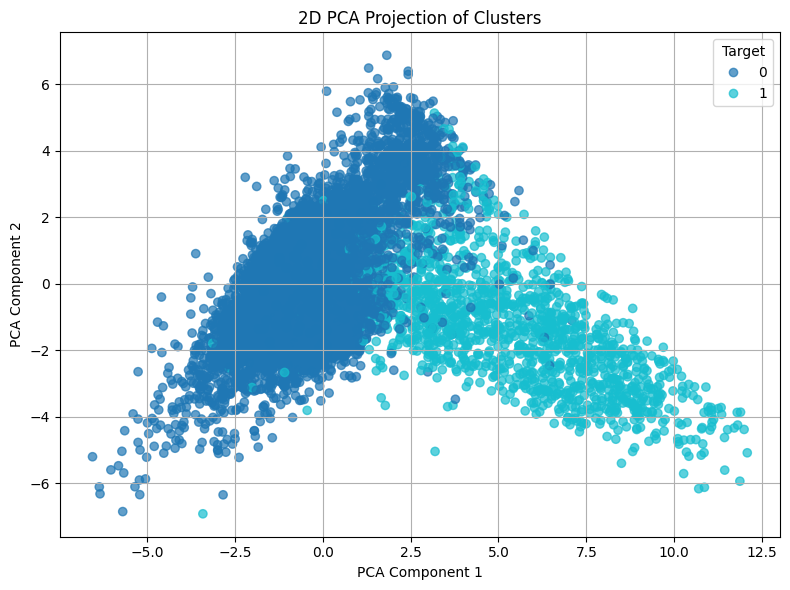

In [15]:
X = df.drop(columns=["target_class"])
y = df["target_class"]

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA to reduce to 2 components
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Plot the PCA-reduced data
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='tab10', alpha=0.7)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('2D PCA Projection of Clusters')
plt.legend(*scatter.legend_elements(), title="Target")
plt.grid(True)
plt.tight_layout()
plt.show()


### Pytorch dataset creation

In [16]:
# To numpy arrays
inputs_df = df.drop("target_class",axis=1)
inputs_arr = inputs_df.to_numpy() 
targets_df = df["target_class"] 
targets_arr = targets_df.to_numpy()
# To torch tensors
inputs=torch.from_numpy(inputs_arr).type(torch.float64)
targets=torch.from_numpy(targets_arr).type(torch.long)
inputs.shape, targets.shape

(torch.Size([17898, 8]), torch.Size([17898]))

In [17]:
dataset=TensorDataset(inputs, targets)

### Train, validation, test split

In [18]:
num_rows=df.shape[0]
val_percent = 0.1 #Porcentaje de validaicón
test_percent = 0.1 #Porcentaje de test
val_size = int(num_rows*val_percent)
test_size = int(num_rows*test_percent)
train_size = num_rows - val_size-test_size

In [19]:
torch.manual_seed(2)#Nos aseguramos de que consigamos la misma validación cada vez.
train_ds, val_ds, test_ds = random_split(dataset, (train_size, val_size, test_size))
print("Muestras de entrenamiento: ",len(train_ds))
print("Muestras de validation:", len(val_ds))
print("Muestras test: ",len(test_ds))

Muestras de entrenamiento:  14320
Muestras de validation: 1789
Muestras test:  1789


In [20]:
batch_size=256

In [21]:
# PyTorch data loaders
train_dl = DataLoader(train_ds, batch_size, num_workers=3, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size, num_workers=3, pin_memory=True)
test_dl = DataLoader(test_ds, batch_size, num_workers=3, pin_memory=True)

GPU/CPU Configuration

In [22]:
# corroboramos el dispositivo
device=get_default_device()
device

device(type='cpu')

In [23]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
test_dl = DeviceDataLoader(test_dl, device)

## NN architecture visualization

It has 4 layers,
with the following number of nodes per layer [8, 16, 16, 2]


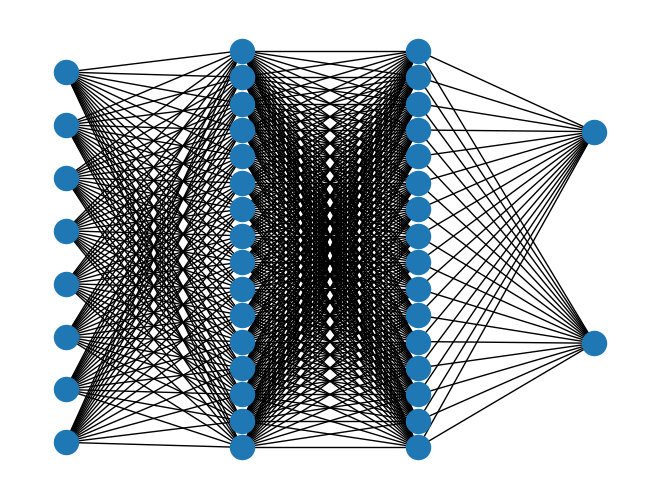

In [24]:
layers = [inputs_df.shape[1], 16, 16, 2]
net = Network(layers)
net.graph(layers)

### Architecture definition in Pytorch

In [25]:
class HTRU2Model(nn.Module):
    def __init__(self,):
        super(HTRU2Model,self).__init__()
        self.layer1 = nn.Linear(8, 16)
        self.layer2 = nn.Linear(16, 16)
        self.layer3 = nn.Linear(16, 2)
        self.softmax = nn.Softmax(dim=1)
    def forward(self, x):
        x = x.float()
        x = self.layer1(x)
        x = F.relu(x)
        x = self.layer2(x)
        x = F.relu(x)
        x = self.layer3(x)
        x = self.softmax(x)
        return x
    def training_step(self, batch):
        inputs, targets = batch 
        out = self(inputs)                  # Generates predictions 
        loss = F.cross_entropy(out, targets) # Calculates loss
        return loss

    def predict_test(self, batch):
        inputs, targets = batch 
        out = self(inputs)                  # Gets predictions 
        return out
    
    def validation_step(self, batch):
        inputs, targets = batch 
        out = self(inputs)                    # Gets predictions
        loss = F.cross_entropy(out, targets)   # Calculates loss
        acc = accuracy(out, targets)           # Calculates accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Calculates cost
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Precision aggregation
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

In [26]:
model = to_device(HTRU2Model(), device)

In [27]:
summary(model, (1,8))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 1, 16]             144
            Linear-2                [-1, 1, 16]             272
            Linear-3                 [-1, 1, 2]              34
           Softmax-4                 [-1, 1, 2]               0
Total params: 450
Trainable params: 450
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


### Model initialization

In [28]:
history = [evaluate(model, val_dl)]
history

/home/gamucerojp/Documents/Programming/repos/PulsarDetectionHTRU2/venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


[{'val_loss': 0.653756320476532, 'val_acc': 0.9105488657951355}]

### Hyperparameters

In [29]:
epochs = 10
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

### Training

In [30]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, val_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

  0%|          | 0/56 [00:00<?, ?it/s]

Epoch [0], last_lr: 0.00275, train_loss: 0.6077, val_loss: 0.4861, val_acc: 0.9474


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch [1], last_lr: 0.00757, train_loss: 0.3633, val_loss: 0.3391, val_acc: 0.9731


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch [2], last_lr: 0.01000, train_loss: 0.3361, val_loss: 0.3358, val_acc: 0.9776


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch [3], last_lr: 0.00950, train_loss: 0.3352, val_loss: 0.3353, val_acc: 0.9771


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch [4], last_lr: 0.00812, train_loss: 0.3349, val_loss: 0.3354, val_acc: 0.9771


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch [5], last_lr: 0.00611, train_loss: 0.3346, val_loss: 0.3357, val_acc: 0.9771


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch [6], last_lr: 0.00389, train_loss: 0.3342, val_loss: 0.3353, val_acc: 0.9771


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch [7], last_lr: 0.00188, train_loss: 0.3339, val_loss: 0.3352, val_acc: 0.9765


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch [8], last_lr: 0.00050, train_loss: 0.3337, val_loss: 0.3351, val_acc: 0.9765


  0%|          | 0/56 [00:00<?, ?it/s]

Epoch [9], last_lr: 0.00000, train_loss: 0.3337, val_loss: 0.3351, val_acc: 0.9765
CPU times: user 13.6 s, sys: 1.96 s, total: 15.5 s
Wall time: 7.86 s


### Precision and loss

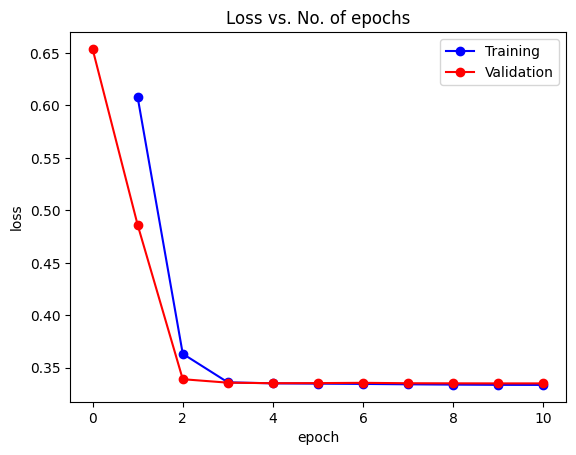

In [31]:
plot_losses(history)

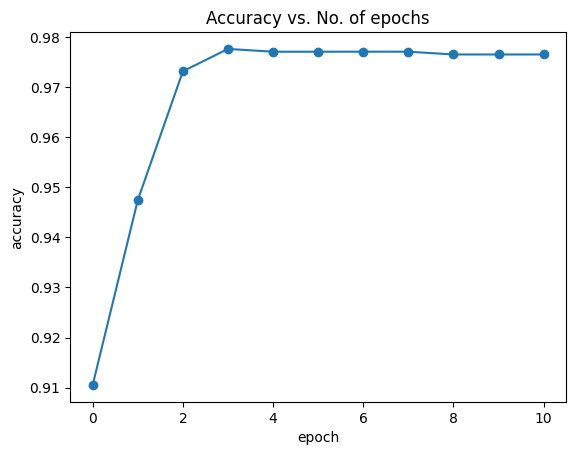

In [32]:
plot_accuracies(history)

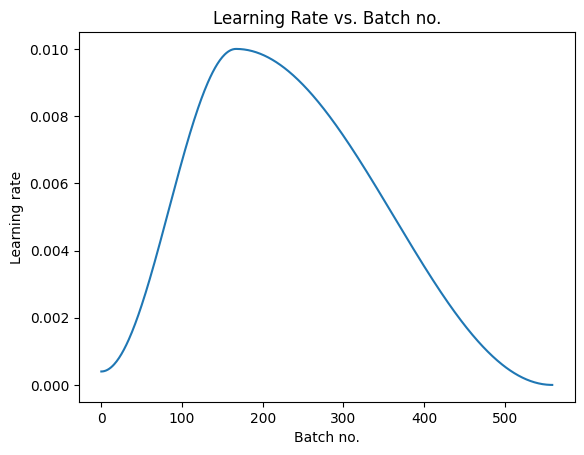

In [33]:
plot_lrs(history)

## Model evaluation in test set

In [34]:
evaluate(model, test_dl)

{'val_loss': 0.32510218024253845, 'val_acc': 0.9888061881065369}

In [35]:
# Unfolding batched predictions
test_probability_predictions_batch = list()
for batch in test_dl:
  test_probability_predictions_batch.append((model.predict_test(batch)))
#----------Empaquetamiento de predicciones-----------------------------------
test_target_probabilities = []
test_target_predictions = []
for i in range(len(test_probability_predictions_batch)):
  for j in range(len(test_probability_predictions_batch[i])):
    test_target_probabilities.append(
      (test_probability_predictions_batch[i][j].detach()).numpy()
    )
    test_target_predictions.append(
      1 if (test_probability_predictions_batch[i][j].detach()).numpy()[1] >= 0.5 else 0 #If second element is higher than 0.5, it's a Pulsar
    )

test_target_probabilities = np.array(test_target_probabilities)
test_target_predictions = np.array(test_target_predictions)

In [36]:
test_target_predictions

array([0, 0, 0, ..., 0, 0, 0], shape=(1789,))

In [37]:
test_target_real = []
for i in range(len(test_ds)):
  test_target_real.append(np.squeeze(test_ds[i][1].numpy()))
test_target_real = np.array(test_target_real)

In [38]:
np.sum(test_target_predictions)

np.int64(164)

In [39]:
np.sum(test_target_real)

np.int64(172)

In [40]:
proba_true_df = pd.DataFrame(test_target_probabilities, columns=["not_pulsar", "is_pulsar"])
proba_true_df["true"] = test_target_real

<Axes: xlabel='is_pulsar', ylabel='Density'>

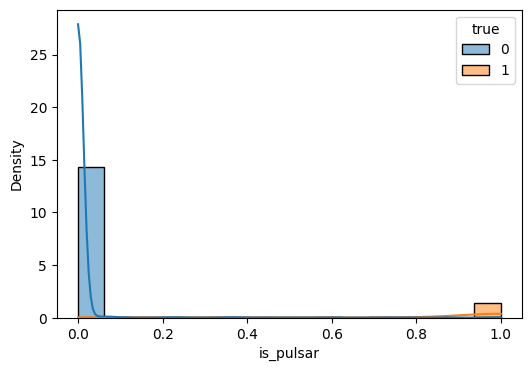

In [41]:
fig, ax = plt.subplots(figsize=(6,4))
sns.histplot(
    proba_true_df,
    x="is_pulsar",
    hue="true",
    bins=16,
    kde=True,
    stat="density",
    ax=ax
)
#ax.set_yscale("log")

In [42]:
arr = confusion_matrix(test_target_real, test_target_predictions).T
arr

array([[1611,   14],
       [   6,  158]])

In [43]:
arr = confusion_matrix(test_target_real, test_target_predictions, normalize = 'true').T
arr = 100*arr
arr

array([[99.62894249,  8.13953488],
       [ 0.37105751, 91.86046512]])

In [44]:
df_cm = pd.DataFrame(
    arr, 
    index = ["Negative","Positive"],
    columns = ["Negative","Positive"]
)

In [45]:
df_cm

,Negative,Positive
Negative,99.628942,8.139535
Positive,0.371058,91.860465


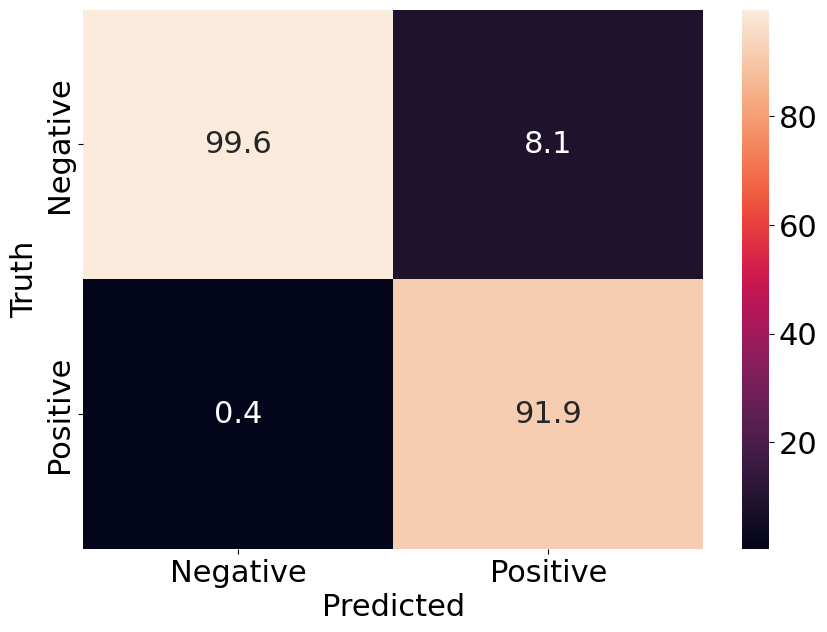

In [46]:
plt.figure(figsize = (10,7))
plt.rcParams.update({'font.size': 22})
ax = sns.heatmap(df_cm, annot=True, fmt=".1f")
ax.set(xlabel=r'Predicted', ylabel=r'Truth');